In [ ]:

import csv
from six import StringIO
import tempfile
import numpy as np

from tensor2tensor.data_generators import problem
from tensor2tensor.layers import common_layers
from tensor2tensor.models import transformer
from tensor2tensor.utils import registry
from tensor2tensor.utils import t2t_model

from tensor2tensor.data_generators import generator_utils
from tensor2tensor.data_generators import text_problems
from tensor2tensor.utils import metrics

import tensorflow as tf

import tk

from tk.models import similarity_transformer
from tk.data_generators import function_docstring

from tk.experiment import configure_experiment, T2TExperiment

from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()
Modes = tf.estimator.ModeKeys


In [1]:

# Run separately (with fresh kernel b/c currently allen_demo initializes tfe.)
from tk.allen_demo import event_data_for_comparison, show_experiment_loss
%matplotlib inline


In [ ]:

tmp_dir = "/mnt/nfs-east1-d/tmp"
data_dir = "/mnt/nfs-east1-d/data"
multi_problem = function_docstring.GithubFunctionDocstring()
multi_problem.generate_data(data_dir, tmp_dir)


# Multi-problem, single network experiment

Here we'll experiment with a problem that mixes the two in-painting example types, using the same network to solve both problems. This is towards training a single encoder that can later be used for both doc strings and code, circumventing the need to specifically train code and doc strings to be embedded into the same space.


## Problem definition

In [2]:

def _random_mask_sequence(sequence):
  """'quick brown fox' -> 'quick ##### fox'"""
  arr = sequence.split()
  ind = np.random.randint(len(arr))
  arr[ind] = ''.join(["#" for _ in range(0, len(arr[ind]))])
  return ' '.join(arr)


In [3]:

# TODO: Could yield with certain probabilities to control abundance
# TODO: In-paintable region could be of variable size and distribution
# TODO: Do this using preprocess step instead of generating completely new set of examples?

@registry.register_problem
class GithubMultiProblemBase(function_docstring.GithubFunctionDocstring):
  """Code in-painting given randomly ablated regions."""

  def generate_samples(self, data_dir, tmp_dir, dataset_split):
    csv_files = self.get_csv_files(data_dir, tmp_dir, dataset_split)

    for pairs_file in csv_files:
      tf.logging.debug("Reading {}".format(pairs_file))
      with tf.gfile.Open(pairs_file) as csv_file:
        for line in csv_file:
          reader = csv.reader(StringIO(line))
          for docstring_tokens, function_tokens in reader:

            yield {
                "inputs": _random_mask_sequence(function_tokens),
                "targets": function_tokens,
                "embed_code": [0]
            }

            yield {
                "inputs": _random_mask_sequence(docstring_tokens),
                "targets": docstring_tokens,
                "embed_code": [0]
            }


In [ ]:

tmp_dir = "/mnt/nfs-east1-d/tmp"
data_dir = "/mnt/nfs-east1-d/data"
multi_problem = GithubMultiProblemBase()
multi_problem.generate_data(data_dir, tmp_dir)


## Training

In [9]:

args = configure_experiment("cs-multi1",
                             problem="github_multi_problem_base",
                             hparams_set="transformer_tiny",
                             model="transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=10000)

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'transformer_tiny',
 'log_device_placement': False,
 'model': 'transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-multi1/cs-multi1-j1014-1845-b89f/output',
 'problem': 'github_multi_problem_base',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-multi1/cs-multi1-j1014-1845-b89f/tk',
 'train_steps': 10000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-14 19:08:24,352] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-10-14 19:08:25,466] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-14 19:08:25,891] Finished loading event data for comparison.


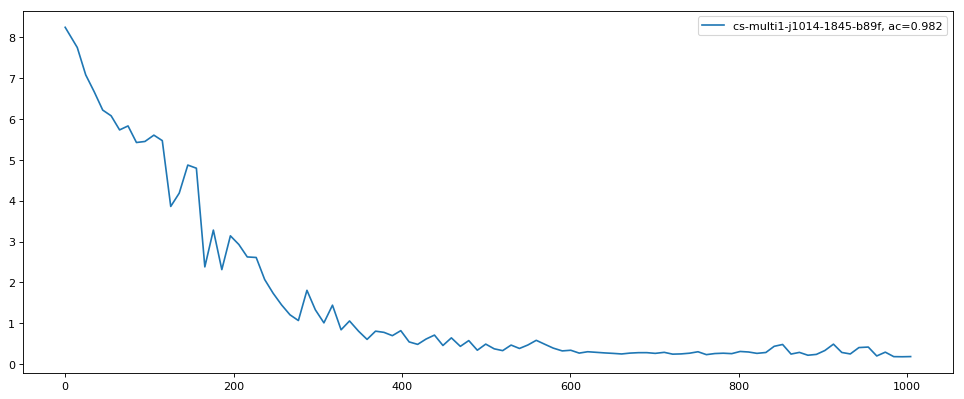

In [2]:

#from tk.allen_demo import event_data_for_comparison, show_experiment_loss
#%matplotlib inline

experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-multi1*")
show_experiment_loss(experiment_data)


In [2]:

# With more examples
# Will ignore the extra data in examples

args = configure_experiment("cs-multi2",
                             problem="github_constrained_embedding",
                             hparams_set="transformer_tiny",
                             model="transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=10000)

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'transformer_tiny',
 'log_device_placement': False,
 'model': 'transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-multi2/cs-multi2-j1017-1822-2319/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'continuous_train_and_evaluate',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-multi2/cs-multi2-j1017-1822-2319/tk',
 'train_steps': 10000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


In [ ]:

experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-multi1*")
show_experiment_loss(experiment_data)


## Alternative problem

Hmmm so there's no guarantee pairs will be embedded in a similar way here. But it might just happen. But if not, can train at the same time to produce corresponding embeddings...

This supposes our examples are of the form: 

```python
{
    "inputs": "some input, e.g. masked code",
    "targets": "some corresponding target, e.g. unmasked code",
    "docstring": "a docstring to embed",
    "code": "code to embed"
}
```

where the inputs/targets pair is only masked docstring/docstring or masked code/code for the sake of simplicity of implementation. if we only do one at a time instead of both then we can just return the tensor produced by super(Transformer, self).body() instead of having to manually call self.loss.


In [18]:

from tensor2tensor.layers import common_layers

def random_mask(tensor):
  mask = tf.random_uniform(common_layers.shape_list(tensor),
                           0, 10, dtype=tf.float32)
  mask = tf.cast(tf.greater(mask, 1), tf.int64)
  return tf.multiply(tensor, mask)

@registry.register_problem
class GithubConstrainedEmbedding(function_docstring.GithubFunctionDocstring):

  def dataset_filename(self):
    return "github_function_docstring"  # Reuse base problem data

  def preprocess_example(self, example, mode, hparams):

    example["docstring"] = example["inputs"]
    example["code"] = example["targets"]
    if np.random.randint(2) == 0:
      # docstring un-masking
      example["targets"] = example["inputs"]
      example["inputs"] = random_mask(example["inputs"])
    else:
      # code un-masking
      example["inputs"] = random_mask(example["targets"])

    return example


It would be a lot cleaner to just have a variety of example types (non-overlapping) and have body be conditional on the example type code.

In [19]:

tmp_dir = "/mnt/nfs-east1-d/tmp"
data_dir = "/mnt/nfs-east1-d/data"
mp_constrained_embedding = GithubConstrainedEmbedding()
mp_constrained_embedding.generate_data(data_dir, tmp_dir)


INFO:tensorflow:Found vocab file: /mnt/nfs-east1-d/data/vocab.github_function_docstring.8192.subwords


[2018-10-17 17:56:18,820] Found vocab file: /mnt/nfs-east1-d/data/vocab.github_function_docstring.8192.subwords


INFO:tensorflow:Skipping generator because outputs files exist


[2018-10-17 17:56:18,895] Skipping generator because outputs files exist


INFO:tensorflow:Skipping shuffle because output files exist


[2018-10-17 17:56:18,902] Skipping shuffle because output files exist


In [20]:

train_dataset = mp_constrained_embedding.dataset(Modes.TRAIN, data_dir)
ds = tfe.Iterator(train_dataset)
print ds.next()


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-train*


[2018-10-17 17:56:22,558] Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-10-17 17:56:22,583] partition: 0 num_data_files: 100


{'code': <tf.Tensor: id=70, shape=(156,), dtype=int64, numpy=
array([   7, 4728,  867,  103, 4728,  867,  103,   83,   83, 5337,    4,
        404, 5802,  969,  259,   87, 1451, 1838,  281, 2184,   49,    8,
        487,   25, 2254,   72,   11,  103, 1140,  259,   87,  308,   46,
        138,   17,  297, 5757,    4, 8182,    4,  971,   72,  360,   48,
          8,  487,  754,   25, 1926, 4850, 1133, 1168,  280, 5611, 7955,
         69,  135,   11,    8,  173,  128,   11, 6800,   66,  275, 5098,
        656,    7,   35,  179,  270,   72,   48,   17, 8011,   31,    8,
        500,   72,    5, 4593, 2427,   78, 1175,    5, 4262, 4593, 2427,
         78, 1175, 4728,  867,    5, 4262, 4593, 2427,  258,  103, 5217,
       1736,  723,  160,   21, 6382,   22,   13,   72,   11,  258,  180,
         72, 6625,    6,   26,  180,  322, 1092,   50,   72,   50,  180,
          6, 6382,   20,   22, 6382, 1092,   38, 6382,  235, 6382, 1092,
          6, 6382,   20,   26,   22,   28, 6382,   10,   13,  

### Model

In [21]:

from tensor2tensor.models.transformer import Transformer
from tk.models.similarity_transformer import similarity_cost

@registry.register_model
class ConstrainedEmbeddingTransformer(Transformer):

  def body(self, features):
    hparams = self._hparams
    target_space = problem.SpaceID.EN_TOK

    if self._hparams.mode == tf.estimator.ModeKeys.PREDICT:
      encoded, _ = self.encode(features["predictme"], target_space, hparams,
                               features=features)
      return tf.reduce_mean(encoded, axis=1), {"training": 0.0}
  
    features_alt = {"inputs":features["docstring"], "targets":features["code"]}
    features_alt = self.bottom(features_alt)

    string_embedding, _ = self.encode(features_alt["inputs"], target_space, hparams,
                                      features=features_alt)
    string_embedding = tf.reduce_mean(string_embedding, axis=1)
    code_embedding, _ = self.encode(features_alt["targets"], target_space, hparams,
                                    features=features_alt)
    code_embedding = tf.reduce_mean(code_embedding, axis=1)
    
    sc = similarity_cost(string_embedding, code_embedding, self.hparams.loss_variant)

    ret = super(ConstrainedEmbeddingTransformer, self).body(features)

    if isinstance(ret, tf.Tensor) or isinstance(ret, tf.EagerTensor):
      return ret, {"similarity": sc}
    elif isinstance(ret, tuple):
      if not isinstance(ret[1], dict):
        raise ValueError("Unexpected second type in superclass body return.")
      ret[1]["similarity"] = sc
      return ret


#### Model testing

Let's verify our model trains with tfe as implemented.

In [22]:

hparams = similarity_transformer.similarity_transformer_tiny()
hparams.data_dir = data_dir

p_hparams = mp_constrained_embedding.get_hparams(hparams)

model = ConstrainedEmbeddingTransformer(
    hparams, tf.estimator.ModeKeys.TRAIN, p_hparams
)

batch_size = 1
train_dataset = mp_constrained_embedding.dataset(Modes.TRAIN, data_dir)
train_dataset = train_dataset.repeat(None).batch(batch_size)

optimizer = tf.train.AdamOptimizer()


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-10-17 17:56:32,558] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-train*


[2018-10-17 17:56:32,562] Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-10-17 17:56:32,581] partition: 0 num_data_files: 100


In [23]:

@tfe.implicit_value_and_gradients
def loss_fn(features):
  _, losses = model(features)
  return losses["training"]

NUM_STEPS = 10

for count, example in enumerate(tfe.Iterator(train_dataset)):
  loss, gv = loss_fn(example)
  optimizer.apply_gradients(gv)

  if count % 1 == 0:
   print("Step: %d, Loss: %.3f" % (count, loss.numpy()))
  if count >= NUM_STEPS:
   break


INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom


[2018-10-17 17:56:34,152] Transforming feature 'inputs' with symbol_modality_8234_128.bottom


INFO:tensorflow:Transforming 'targets' with symbol_modality_8234_128.targets_bottom


[2018-10-17 17:56:34,384] Transforming 'targets' with symbol_modality_8234_128.targets_bottom


INFO:tensorflow:Building model body


[2018-10-17 17:56:34,392] Building model body


INFO:tensorflow:Transforming body output with symbol_modality_8234_128.top


[2018-10-17 17:56:34,696] Transforming body output with symbol_modality_8234_128.top


Step: 0, Loss: 7.902
Step: 1, Loss: 8.487
Step: 2, Loss: 7.282
Step: 3, Loss: 8.135
Step: 4, Loss: 7.754
Step: 5, Loss: 7.373
Step: 6, Loss: 7.947
Step: 7, Loss: 7.385
Step: 8, Loss: 7.677
Step: 9, Loss: 7.422
Step: 10, Loss: 6.859


## Training

In [1]:

from tk.experiment import configure_experiment, T2TExperiment


In [15]:

args = configure_experiment("cs-ce3",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=10000)

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-ce3/cs-ce3-j1016-2037-f912/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-ce3/cs-ce3-j1016-2037-f912/tk',
 'train_steps': 10000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-16 20:58:19,545] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-10-16 20:58:20,649] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-16 20:58:21,369] Finished loading event data for comparison.


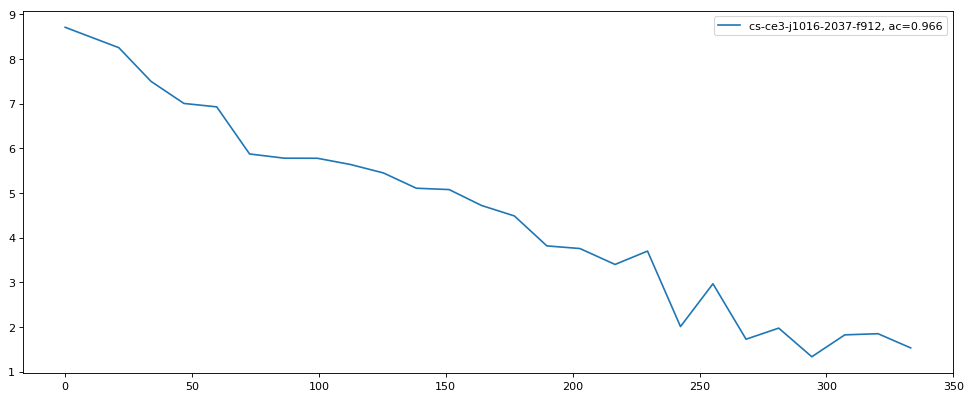

In [6]:
experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-ce3*")
show_experiment_loss(experiment_data)

## Multi-gpu training

In [16]:

args = configure_experiment("cs-gpu4",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=4,
                             num_steps=10000)

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-gpu4/cs-gpu4-j1016-2046-f235/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-gpu4/cs-gpu4-j1016-2046-f235/tk',
 'train_steps': 10000,
 'worker_gpu': 4,
 'worker_gpu_memory_fraction': 0.95}


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-16 21:06:49,480] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-10-16 21:06:50,593] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-16 21:06:51,819] Finished loading event data for comparison.


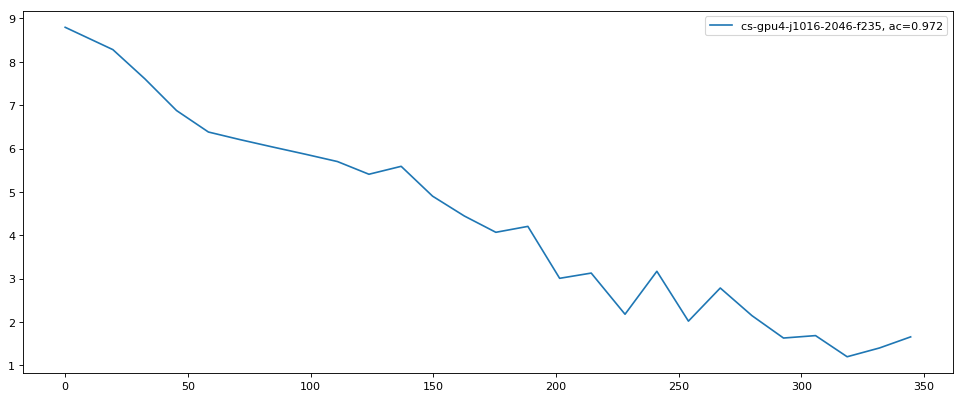

In [3]:
experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-gpu4*")
show_experiment_loss(experiment_data)

In [ ]:
Seeing containers restarting around the same step number ...

## Distributed training

In [5]:

args = configure_experiment("cs-dist",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=10000,
                             num_ps=4,
                             schedule="train_and_evaluate")

job = T2TExperiment(**args)
job.run()


[2018-10-16 21:12:43,870] /mnt/nfs-east1-d/work/tk
[2018-10-16 21:12:43,913] /mnt/nfs-east1-d/work/tk


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-dist/cs-dist-j1016-2112-6e89/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train_and_evaluate',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-dist/cs-dist-j1016-2112-6e89/tk',
 'train_steps': 10000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


[2018-10-16 21:12:52,391] smoke: True


In [ ]:
fails with error 

INFO:tensorflow:worker_gpu=0
INFO:tensorflow:sync=True
Traceback (most recent call last):
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/mnt/nfs-east1-d/comparisons/cs-dist/cs-dist-j1016-2112-6e89/tk/experiment.py", line 400, in <module>
    tf.app.run()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/platform/app.py", line 125, in run
    _sys.exit(main(argv))
  File "/mnt/nfs-east1-d/comparisons/cs-dist/cs-dist-j1016-2112-6e89/tk/experiment.py", line 395, in main
    trainer_main(None)
  File "/mnt/nfs-east1-d/comparisons/cs-dist/cs-dist-j1016-2112-6e89/vendor/tensor2tensor/tensor2tensor/bin/t2t_trainer.py", line 354, in main
    exp = exp_fn(create_run_config(hparams), hparams)
  File "/mnt/nfs-east1-d/comparisons/cs-dist/cs-dist-j1016-2112-6e89/vendor/tensor2tensor/tensor2tensor/bin/t2t_trainer.py", line 227, in create_run_config
    intra_op_parallelism_threads=FLAGS.intra_op_parallelism_threads)
  File "/mnt/nfs-east1-d/comparisons/cs-dist/cs-dist-j1016-2112-6e89/vendor/tensor2tensor/tensor2tensor/utils/trainer_lib.py", line 171, in create_run_config
    no_data_parallelism=no_data_parallelism)
  File "/mnt/nfs-east1-d/comparisons/cs-dist/cs-dist-j1016-2112-6e89/vendor/tensor2tensor/tensor2tensor/utils/devices.py", line 137, in data_parallelism
    assert not sync
AssertionError

In [6]:

args = configure_experiment("cs-dist-tr",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=10000,
                             num_ps=4,
                             schedule="train")

job = T2TExperiment(**args)
job.run()


[2018-10-16 21:15:24,949] /mnt/nfs-east1-d/work/tk
[2018-10-16 21:15:24,959] /mnt/nfs-east1-d/work/tk


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr/cs-dist-tr-j1016-2115-ca9f/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr/cs-dist-tr-j1016-2115-ca9f/tk',
 'train_steps': 10000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


[2018-10-16 21:15:36,075] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-16 21:56:08,103] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-10-16 21:56:09,357] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-16 21:56:13,612] Finished loading event data for comparison.


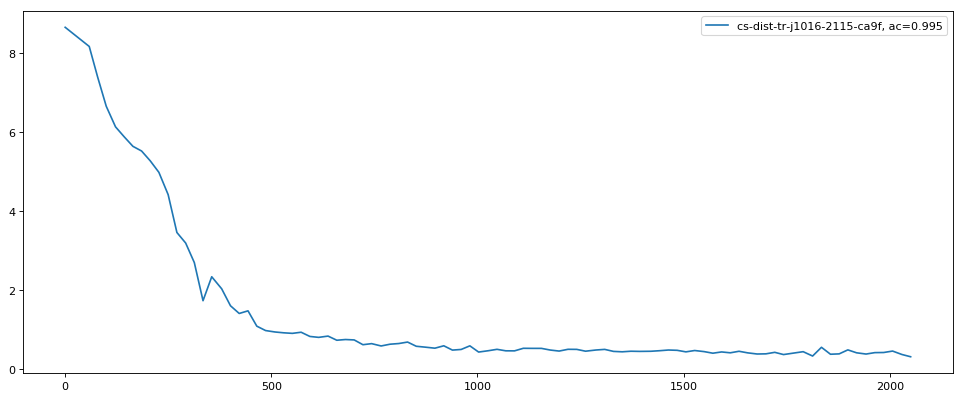

In [2]:
experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr*")
show_experiment_loss(experiment_data)

My guess is that it is indeed using all of the workers because the loss curve looks much smoother than that of the single gpu condition. I am not clear on why the 4x gpu condition isn't smoother as well though (perhaps it's misconfigured).

In [26]:

# Repeat run with more examples

args = configure_experiment("cs-dist-tr-morex",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=5000,
                             num_ps=4,
                             schedule="train")

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr-morex/cs-dist-tr-morex-j1017-1758-a24a/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr-morex/cs-dist-tr-morex-j1017-1758-a24a/tk',
 'train_steps': 5000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-17 18:23:45,337] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-10-17 18:23:46,665] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-17 18:23:50,768] Finished loading event data for comparison.


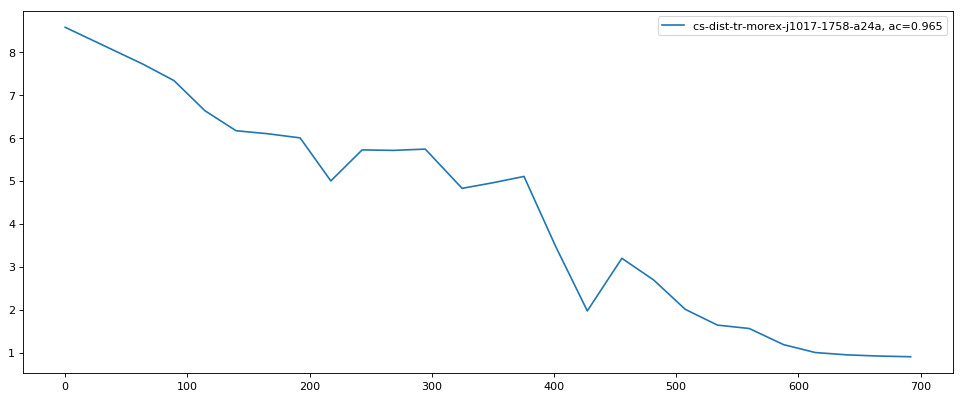

In [2]:
experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr-morex*")
show_experiment_loss(experiment_data)

### Vlarge distributed training

Does it get even smoother? Does it converge faster?

In [4]:

args = configure_experiment("cs-dist-tr-12",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                             },
                             num_gpu_per_worker=1,
                             num_steps=3000,
                             num_ps=12,
                             schedule="train")

job = T2TExperiment(**args)
job.run()


[2018-10-16 22:17:03,006] /mnt/nfs-east1-d/work/tk
[2018-10-16 22:17:03,081] /mnt/nfs-east1-d/work/tk


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "''",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr-12/cs-dist-tr-12-j1016-2217-4c5e/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr-12/cs-dist-tr-12-j1016-2217-4c5e/tk',
 'train_steps': 3000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


[2018-10-16 22:17:12,897] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-16 22:44:42,161] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 2)


[2018-10-16 22:44:43,466] Processing experiment events (1 of 2)


INFO:tensorflow:Processing experiment events (2 of 2)


[2018-10-16 22:44:53,896] Processing experiment events (2 of 2)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-16 22:44:57,917] Finished loading event data for comparison.


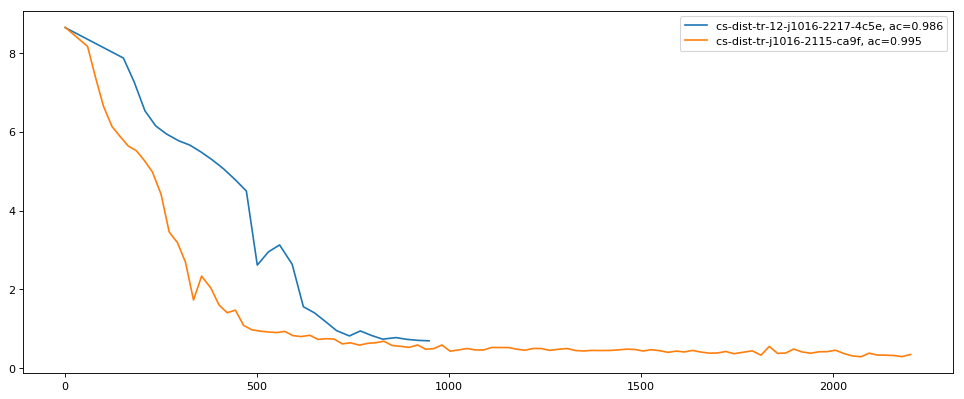

In [9]:
experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr*")
show_experiment_loss(experiment_data)

Ah these might not be comparable, is there a different effective step number with more workers?

Might be better at extracting last little bit of improvement by virtue of ironing out volatility that is happing on this scale (by virtue of the larger effective batch size). But didn't run it long enough to see that.

Are all the workers running with different random seeds?

## Ready model for inference

We'll need to make sure our model can be used for inference in the way we plan to. Then, we'll need to acutually export it to be used in the function embedding dataflow.

In [1]:

import numpy as np

from tk.models import similarity_transformer
from tk.data_generators import function_docstring
import tensorflow as tf
from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()
Modes = tf.estimator.ModeKeys


### tf.Eager inference

In [2]:

data_dir = "/mnt/nfs-east1-d/data"

mp_constrained_embedding = function_docstring.GithubConstrainedEmbedding()

# Get the encoders from the problem
encoders = mp_constrained_embedding.feature_encoders(data_dir)

# Setup helper functions for encoding and decoding
def encode(input_str, output_str=None):
  """Input str to features dict, ready for inference"""
  inputs = encoders["inputs"].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(inputs, [1, -1, 1])  # Make it 3D.
  return {"inputs": batch_inputs}

def decode(integers):
  """List of ints to str
  
  For decoding an integer encoding to its string representation,
  not for decoding an embedding vector into the same.
  """
  integers = list(np.squeeze(integers))
  if 1 in integers:
    integers = integers[:integers.index(1)]
  return encoders["inputs"].decode(np.squeeze(integers))


In [3]:

hparams = similarity_transformer.similarity_transformer_tiny()
hparams.data_dir = data_dir

p_hparams = mp_constrained_embedding.get_hparams(hparams)

model = similarity_transformer.ConstrainedEmbeddingTransformer(
    hparams, tf.estimator.ModeKeys.PREDICT, p_hparams
)

ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr-morex/cs-dist-tr-morex-j1017-1758-a24a/output/model.ckpt-5000"

def embed_query(ckpt_path, model, query_string):
  """Use tf.Eager to embed query locally."""
  with tfe.restore_variables_on_create(ckpt_path):
    embedding, _ = model(encode(query_string))
    return embedding.numpy()


INFO:tensorflow:Setting T2TModel mode to 'infer'


[2018-10-18 23:22:21,628] Setting T2TModel mode to 'infer'


INFO:tensorflow:Setting hparams.layer_prepostprocess_dropout to 0.0


[2018-10-18 23:22:21,632] Setting hparams.layer_prepostprocess_dropout to 0.0


INFO:tensorflow:Setting hparams.symbol_dropout to 0.0


[2018-10-18 23:22:21,634] Setting hparams.symbol_dropout to 0.0


INFO:tensorflow:Setting hparams.attention_dropout to 0.0


[2018-10-18 23:22:21,638] Setting hparams.attention_dropout to 0.0


INFO:tensorflow:Setting hparams.dropout to 0.0


[2018-10-18 23:22:21,641] Setting hparams.dropout to 0.0


INFO:tensorflow:Setting hparams.relu_dropout to 0.0


[2018-10-18 23:22:21,645] Setting hparams.relu_dropout to 0.0


In [6]:

# Currently having trouble restoring a checkpoint, not able to find 
# constrained_embedding_transformer/symbol_modality_8234_128/shared/weights_0
# in the checkpoint. Is that because we called super(CET, self).body() in CET.body()? We could just take a look
# at the contents of the checkpoint to see,

# Looking at the checkpoint I see paths like
# constrained_embedding_transformer/body/symbol_modality_8185_128/shared/weights_9

# Ah, I think this is because the vocab was re-generated (for a larger set of examples) since this model was
# trained. Let's try using one that was trained more recently.


In [4]:

embed_query(ckpt_path, model, "def get_data_home return base save_data_path PACKAGE_NAME")

# Yep it works.


INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom


[2018-10-18 16:30:22,997] Transforming feature 'inputs' with symbol_modality_8234_128.bottom


INFO:tensorflow:Building model body


[2018-10-18 16:30:23,036] Building model body


INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


[2018-10-18 16:30:23,108] Skipping T2TModel top and loss because training loss returned from body


array([[-0.21631537,  0.21199477, -0.06496788, -0.1881274 , -0.09062081,
        -0.21399653,  0.01594124,  0.18679456, -0.2807848 ,  0.23914964,
        -0.59417397,  0.20313282,  0.41784644,  0.45253548, -0.0249283 ,
         0.4818108 ,  0.6589859 ,  0.6463783 ,  1.2422936 ,  0.48913962,
         0.33428043,  0.28655237, -0.07137743, -0.23938744, -0.23709907,
        -0.23413683,  0.14676976,  0.49466872, -1.0738295 , -0.6268798 ,
         0.23479004, -1.1729021 , -1.0582638 , -0.70819294, -0.861267  ,
         0.4800421 , -0.35979506, -0.34006515, -1.3472264 , -0.55586374,
        -0.8726017 ,  0.08508495, -1.1255118 , -0.9703183 , -0.91921544,
        -1.1283381 , -0.7716562 , -0.44353375, -0.36567417, -1.9120712 ,
        -0.5933587 , -1.1531428 , -0.3867917 ,  0.04375548, -1.0515258 ,
         0.7565938 , -0.4031889 , -0.02354081,  0.00389782,  0.2451246 ,
        -0.57402474, -1.0834739 ,  0.25787947,  0.46268559, -0.491924  ,
         0.34762102,  0.17876334, -0.2727155 , -0.4

### Export

In [18]:

# Can just do this with t2t_export instead.

!/home/jovyan/.conda/envs/py2/bin/python -m tk.export_model


INFO:tensorflow:Importing user module tk from path /home/jovyan/nfs-work/tk
[2018-10-18 16:48:14,641] Importing user module tk from path /home/jovyan/nfs-work/tk
INFO:tensorflow:schedule=continuous_train_and_eval
[2018-10-18 16:48:14,707] schedule=continuous_train_and_eval
INFO:tensorflow:worker_gpu=1
[2018-10-18 16:48:14,707] worker_gpu=1
INFO:tensorflow:sync=False
[2018-10-18 16:48:14,707] sync=False
INFO:tensorflow:datashard_devices: ['']
[2018-10-18 16:48:14,707] datashard_devices: ['']
INFO:tensorflow:caching_devices: None
[2018-10-18 16:48:14,707] caching_devices: None
INFO:tensorflow:ps_devices: ['gpu:0']
[2018-10-18 16:48:14,708] ps_devices: ['gpu:0']
INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_keep_checkpoint_max': 20, '_task_type': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f31203e0d90>, '_keep_checkpoint_every_n_hours': 10000, '_session_config': gpu_options {
  per_process_gpu_memory_fraction: 0.95
}
allow_soft

#### Stage exported model to GCS

In [ ]:
!gsutil -m cp -r /mnt/nfs-east1-d/ckpts/cs-dist-tr-morex-j1017-1758-a24a/output/export/Servo/1539881298 \
    gs://kubeflow-rl-models

In [21]:
EXPORTED_MODEL_PATH="gs://kubeflow-rl-models/1539881298"

## Qualitative analysis

#### Embedding distances

In [4]:

from tk.models.similarity_transformer import similarity_cost, _cosine_similarity

import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline


In [5]:
# TODO: For a set of N code/doc string pairs, genearate a heat map that
# shows the pairwise distances between self- and non-self pairs 

data_dir = "/mnt/nfs-east1-d/data"

batch_size = 1
train_dataset = mp_constrained_embedding.dataset(Modes.PREDICT, data_dir)
train_dataset = train_dataset.repeat(None).batch(batch_size)

itereator = tfe.Iterator(train_dataset)


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-dev*


[2018-10-18 23:22:30,499] Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-dev*


INFO:tensorflow:partition: 0 num_data_files: 1


[2018-10-18 23:22:30,506] partition: 0 num_data_files: 1


In [80]:

# All this because currently having issues with running model on batch sizes >1 with tfe.
# Obviously you could just have two batches of embedding tensors and normalize and matmul them.

def _compute(ckpt_path, model):
    embeddings = []
    num_examples = 100

    with tfe.restore_variables_on_create(ckpt_path):

      for i in range(0, num_examples):
        example = itereator.next()

        doc_emb, _ = model({"inputs": example["docstring"]})
        code_emb, _ = model({"inputs": example["code"]})

        embeddings.append([doc_emb, code_emb, decode(example["docstring"]), decode(example["code"])])

    distances = np.zeros((num_examples, num_examples))

    for i in range(0, num_examples):
      for j in range(0, num_examples):
        distances[i][j] = _cosine_similarity(embeddings[i][0], embeddings[j][1])
    
    return distances, embeddings
  

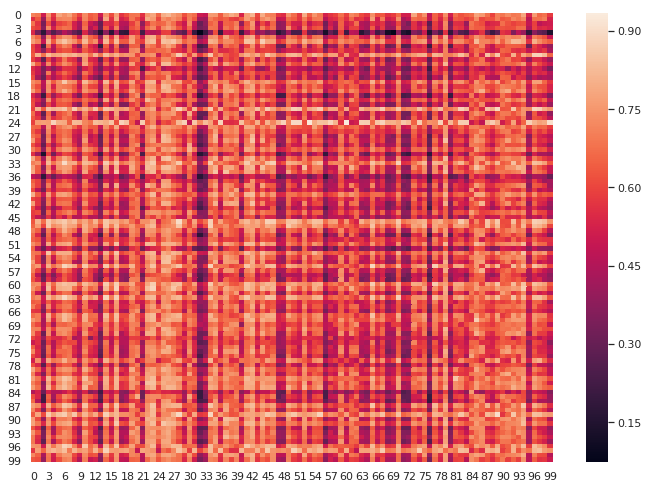

In [81]:

distances_a, embeddings_a = _compute(ckpt_path, model)

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances_a)


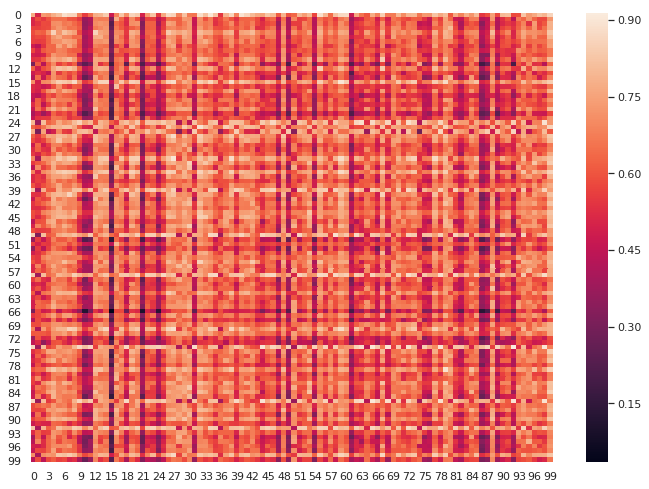

In [82]:

distances_b, embeddings_b = _compute(ckpt_path, model)

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances_b)


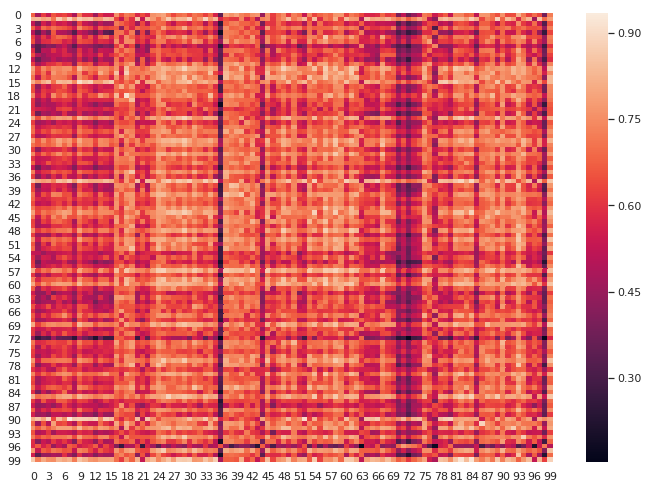

In [83]:

distances_c, embeddings_c = _compute(ckpt_path, model)

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances_c)


In [ ]:
# I don't know whether the apparent blockiness is random or a problem but I'm guessing it's random.

# Ideally it would be nice to be able to mouse over this and see what pairs correspond to what positions.

In [37]:

print(embeddings_c[23][2] + "\n")
print(embeddings_c[24][2] + "\n")
print(embeddings_c[25][2] + "\n")

print(embeddings_c[38][2] + "\n")
print(embeddings_c[39][2] + "\n")
print(embeddings_c[40][2] + "\n")


wait for the initialized instance to be gone .

user detail change on customer ui

checks if the specified edge id1 -- id2 exists . : param id1 : node i d . : param id2 : node i d . : return : a boolean indicating if the edge exists .

d = distance_from_soma(segname ) returns the distance of the segment from the center of the soma . segname should have be a string that follows the convention how the neuron refers to a point in a segment , e.g. , ' dend1[802](0.5 ) ' .

builds the computation graph consisting of training / testing lenet

return the segments stored in the adapter storage .



In [67]:
# This is an aggregate measure of the extent to which true pairs associate with non pairs in the same way
# i.e. d(a1, b2) should be similar to d(a2, b1) for pairs (a1, b1) and (a2, b2).

np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)

# The error here is normalized by the number of elements compared. The error per element should be around zero.

0.18182619293928146

In [69]:
np.sum(np.abs(distances-np.flip(distances, 0)))/(np.shape(distances)[0]**2)
# We can get a baseline for this difference by differencing un-related pairs

0.10624137333631516

INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-18 23:16:00,704] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-10-18 23:16:02,002] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-18 23:16:06,189] Finished loading event data for comparison.


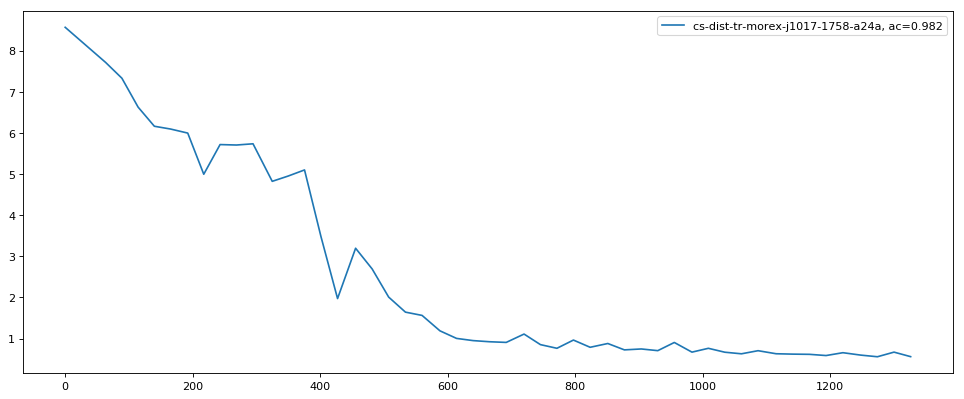

In [2]:
# Here's the loss plot for the training run that produced the checkpoints we're using here
experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr-morex*")
show_experiment_loss(experiment_data)

In [61]:
distances[5][7]

0.7318442463874817

In [62]:
distances[7][5]

0.3528933823108673

In [70]:
_cosine_similarity(embeddings[5][0], embeddings[7][0])

<tf.Tensor: id=869131, shape=(1, 1), dtype=float32, numpy=array([[0.7676854]], dtype=float32)>

In [71]:
_cosine_similarity(embeddings[5][1], embeddings[7][1])

<tf.Tensor: id=869143, shape=(1, 1), dtype=float32, numpy=array([[0.6097354]], dtype=float32)>

In [63]:
embeddings[5]

[<tf.Tensor: id=664114, shape=(1, 128), dtype=float32, numpy=
 array([[-0.16624993,  0.1815849 , -0.66394997, -0.29873937,  0.6153131 ,
         -0.18159673, -0.39539593,  0.1364375 ,  0.77071244, -0.48493177,
         -0.40928522,  0.45472282, -1.1008351 , -0.572319  , -0.43420517,
         -0.35236022,  0.5690034 ,  0.06614585,  0.58036023, -0.34038854,
         -0.14067456, -0.1963357 ,  0.3463128 , -0.09581337, -0.58523715,
         -0.4969741 , -0.518986  , -0.80766845, -0.05410708,  0.49035102,
          0.9278741 , -0.328247  , -1.0907807 , -1.524258  ,  0.52683055,
         -0.04850389, -0.39032406, -0.73416954, -0.32075363, -0.56506205,
          1.1327415 ,  0.11636133, -1.017212  , -0.5097146 , -0.23803134,
         -0.06708574,  0.27644956, -0.08401149,  0.31028518, -0.38305688,
          0.10542833,  0.24393645, -0.19882208, -0.38897628, -0.74468255,
         -0.73743993,  0.10718554, -0.45494303, -0.62399787,  0.91573256,
          0.22370556, -0.3265848 , -0.38916114, -0

In [64]:
embeddings[7]

[<tf.Tensor: id=665913, shape=(1, 128), dtype=float32, numpy=
 array([[-0.40166053, -0.05535857, -0.4084529 , -0.77862984,  0.2908178 ,
         -0.5584004 , -0.49329227, -0.19387504, -0.2709269 ,  0.10598635,
         -0.50981927,  0.393827  , -0.12091672, -0.48813054,  0.02515285,
         -0.6151491 ,  0.5296176 ,  0.07617066,  0.335529  , -0.44036433,
         -0.34737113, -0.4495916 , -0.09653226,  0.24309392, -0.6001947 ,
          0.43128484, -0.7490743 , -0.5434878 , -0.2907407 , -0.24595994,
          0.67717326, -0.51027393, -0.9410194 , -0.35907346,  0.6638032 ,
         -0.13903187,  0.15408604, -0.95013803, -0.23586312, -0.5472002 ,
          0.8155243 ,  0.22883333, -0.77579063, -1.6271203 , -0.43910533,
          0.11622116,  0.08199745, -0.15326233,  0.30290574,  0.44416586,
         -0.24103683,  0.03028859, -0.26793653, -0.63115907, -0.52352905,
         -0.06834899,  0.05336336, -1.0111123 , -1.3162576 ,  0.6618201 ,
         -0.45866317, -0.55464613, -0.35785404, -0

In [65]:
_cosine_similarity(embeddings[5][0], embeddings[7][1])

<tf.Tensor: id=869107, shape=(1, 1), dtype=float32, numpy=array([[0.73184425]], dtype=float32)>

In [66]:
_cosine_similarity(embeddings[5][1], embeddings[7][0])

<tf.Tensor: id=869119, shape=(1, 1), dtype=float32, numpy=array([[0.35289338]], dtype=float32)>

In [ ]:
# I believe our loss ignored values on the diagonal so that's one reason it might not be getting the self-similarity values right.

#### Very easy cases

Let's check some even easier cases

In [23]:
embeddings[0][2:]

['this method decorator prevents the method from executing normally if the the input is not lowercase .',
 'def is_lowercase func def wrapper self text if not text islower return is invalid Input should be lowercase format text return func self text return wrapper']

In [24]:
emba, _ = model(encode(embeddings[0][2]))
embb, _ = model(encode(embeddings[0][3]))
_cosine_similarity(emba, embb)
# We would hope this would tend to be closer to 1.0.

<tf.Tensor: id=239276, shape=(1, 1), dtype=float32, numpy=array([[0.7800646]], dtype=float32)>

In [21]:

emba, _ = model(encode("print hello world"))

cases = [
    "print hello world",
    "print hi world",
    "print hey world",
    "perform tree search",
    "solve the poincare conjecture",
    "list the first n prime numbers",
    "start a flask web server"
]

def infer_and_print(docstr):
  embb, _ = model(encode(docstr))
  print(docstr)
  print(_cosine_similarity(emba, embb).numpy()[0][0])
  print()

for case in cases:
  infer_and_print(case)


print hello world
1.0
()
print hi world
0.86921
()
print hey world
0.82131225
()
perform tree search
0.7014419
()
solve the poincare conjecture
0.5837254
()
list the first n prime numbers
0.58074903
()
start a flask web server
0.7093413
()


In [25]:
# So given this and the previous I'd want to take a closer look at whether it's even considering the
# similarity cost in the loss as well as whether that measure it measuring what we think it's measuring.

## Full search index

### Preprocess dataset

In [ ]:

# Might fail given removed TF and T2T dependencies... not sure if it uses those in the preprocess step.

JOB_NAME="preprocess-github-dataset-$(date +'%Y%m%d-%H%M%S')"

!/home/jovyan/.conda/envs/py2/bin/python -m code_search.dataflow.cli.preprocess_github_dataset \
        --runner "DataflowRunner" \
        --project "kubeflow-rl" \
        --target_dataset "github_function_embeddings" \
        --data_dir "gs://kubeflow-rl-dataflow/cs/data" \
        --job_name "preprocess-github-dataset-$(date +'%Y%m%d-%H%M%S')" \
        --temp_location "gs://kubeflow-rl-dataflow/cs/tmp" \
        --staging_location "gs://kubeflow-rl-dataflow/cs/staging" \
        --worker_machine_type "n1-standard-4" \
        --num_workers "16"


In [ ]:

# For me currently the "Docstring Pairs" step within "Tokenize Code" within "Transform Github Dataset" is estimated to take
# 5 days, 7h using about 8 x n1-standard-4 instances. Am I doing something wrong?

# I'm curious whether this is bottlenecked by write to BigQuery. We could write all of the output to CSV's then do a single
# upload.


### Compute function embeddings

In [ ]:

!/home/jovyan/.conda/envs/py2/bin/python -m code_search.dataflow.cli.create_function_embeddings \
        --runner "DataflowRunner" \
        --project "kubeflow-rl" \
        --target_dataset "github_function_embeddings" \
        --problem "github_constrained_embedding" \
        --data_dir "gs://kubeflow-rl-dataflow/cs/data" \
        --saved_model_dir "/mnt/nfs-east1-d/ckpts/cs-dist-tr-morex-j1017-1758-a24a/output/export/Servo/1539881298" \
        --job_name "preprocess-github-dataset-$(date +'%Y%m%d-%H%M%S')" \
        --temp_location "gs://kubeflow-rl-dataflow/cs/tmp" \
        --staging_location "gs://kubeflow-rl-dataflow/cs/staging" \
        --worker_machine_type "n1-standard-4" \
        --num_workers "16"


In [ ]:
# TODO: set local_lookup_data_path

#local_lookup_data_path = "/tmp/cs/lookup_data.csv"
#local_index_save_path = "/tmp/cs/search_index"


## Notes

* So some of the examples had zeros inserted in place of the EOS ID which we don't want.
* When the model is exported we'll need to set the mode to PREDICT if the exported model is to be used for producing embeddings.
* What about randomizing inputs instead of zeroing them out? How can we create a scenario analagous to fixing buggy code?
* Working on object or module level instead of function level? Could it be harder to understand a single function than a function in a broader context?